In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [3]:
import optax

In [4]:
from QCBM import QCBM, KLDivergence, MMD

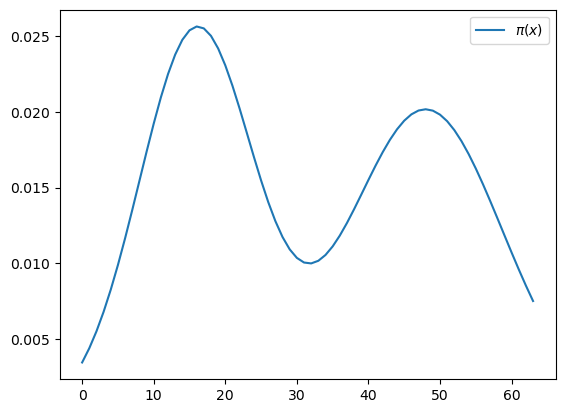

In [5]:
def mixture_gaussian_pdf(x, mus, sigmas):
    mus, sigmas = np.array(mus), np.array(sigmas)
    vars = sigmas**2
    values = [
        (1 / np.sqrt(2 * np.pi * v)) * np.exp(-((x - m) ** 2) / (2 * v)) for m, v in zip(mus, vars)
    ]
    values = np.sum([val / sum(val) for val in values], axis=0)
    return values / np.sum(values)


n_qubits = 6
x_max = 2**n_qubits
x_input = np.arange(x_max)
mus = [(1 / 4) * x_max, (3 / 4) * x_max]
sigmas = [x_max / 8, x_max/6]
data = mixture_gaussian_pdf(x_input, mus, sigmas)

plt.plot(data, label=r"$\pi(x)$")
plt.legend()
plt.show()

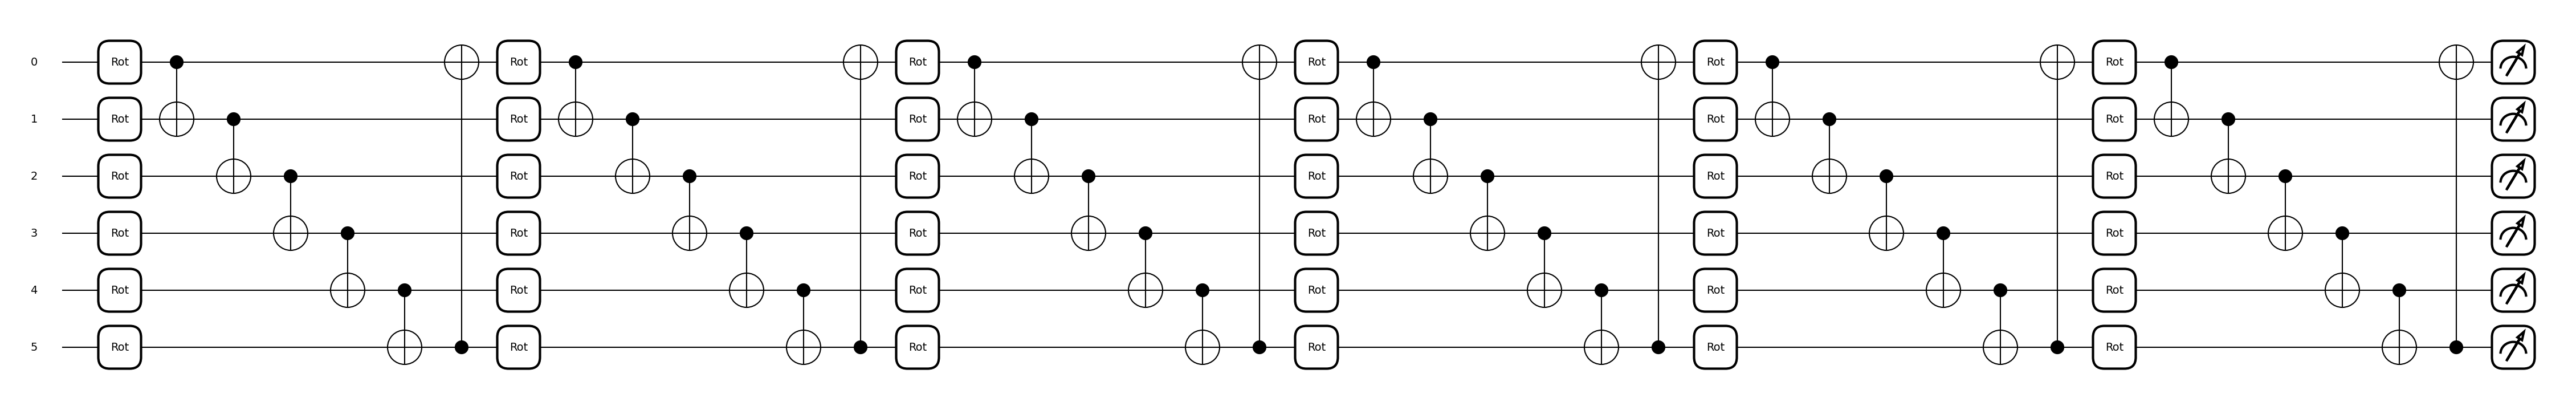

In [6]:
dev = qml.device("default.qubit", wires=n_qubits)

n_layers = 6
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)


@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(
        weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
    )
    return qml.probs()


jit_circuit = jax.jit(circuit)

qml.draw_mpl(circuit, level="device")(weights)
plt.show()

In [ ]:
bandwidth = jnp.array([0.25, 60])
space = jnp.arange(2**n_qubits)

opt = optax.adam(learning_rate=0.1)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, data)

opt_state = opt.init(weights)

# @jax.jit
# def update_step(params, opt_state):
#     (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.loss_fn, has_aux=True)(params)
#     updates, opt_state = opt.update(grads, opt_state)
#     params = optax.apply_updates(params, updates)
#     kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
#     return params, opt_state, loss_val, kl_div

history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.loss_fn, has_aux=True)(weights)
    updates, opt_state = opt.update(grads, opt_state)
    weights = optax.apply_updates(weights, updates)
    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

Step: 0 Loss: 0.0077 KL-div: 0.5428
Step: 10 Loss: 0.0020 KL-div: 0.1941
Step: 20 Loss: 0.0005 KL-div: 0.0370
Step: 30 Loss: 0.0002 KL-div: 0.0163
Step: 40 Loss: 0.0001 KL-div: 0.0055
Step: 50 Loss: 0.0000 KL-div: 0.0033
Step: 60 Loss: 0.0000 KL-div: 0.0015
Step: 70 Loss: 0.0000 KL-div: 0.0009
Step: 80 Loss: 0.0000 KL-div: 0.0004
Step: 90 Loss: 0.0000 KL-div: 0.0001
